# Do taller athletes perform better in the olympics?

By: Jacob Kao

Date: 8/21/23

### Import Libraries

In [4]:
#Data manipulation
import pandas as pd
import numpy as np

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns


### Load Dataset

In [5]:
path = "athlete_events.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()


(271116, 15)


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### Handle Null Values

See where null values are:

In [6]:
df.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

<Axes: >

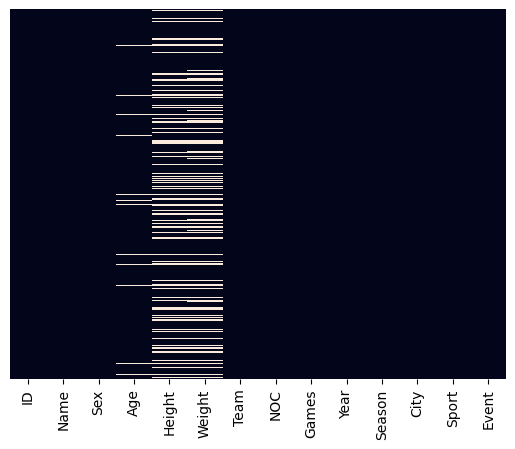

In [7]:
df_no_medal = df.drop("Medal", axis=1)
sns.heatmap(df_no_medal.isnull(), yticklabels=False, cbar=False)

A null value in the "Medal" column means the athlete did not win a medal, so those values can be kept. However, the other null values (in height, weight, and age) will be filled using **mean imputation** in order to preserve sample size.

In [8]:
mean_age = df['Age'].mean()
mean_weight = df['Weight'].mean()
mean_height = df['Height'].mean()

df['Age'] = df['Age'].fillna(mean_age)
df['Weight'] = df['Weight'].fillna(mean_weight)
df['Height'] = df['Height'].fillna(mean_height)

Verify that all null values were removed.

<Axes: >

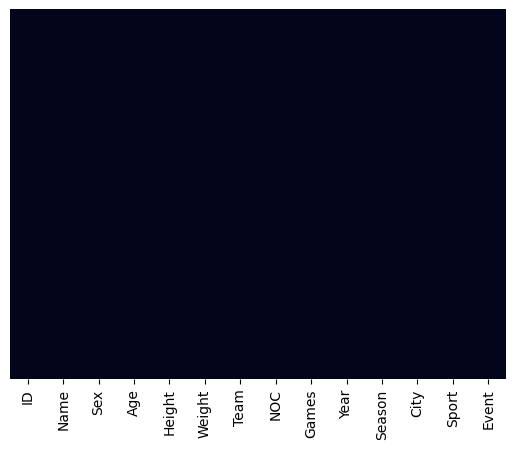

In [9]:
df_no_medal = df.drop("Medal", axis=1)
sns.heatmap(df_no_medal.isnull(), yticklabels=False, cbar=False)

Visualization of mean imputation of age.

<Axes: xlabel='Age', ylabel='Count'>

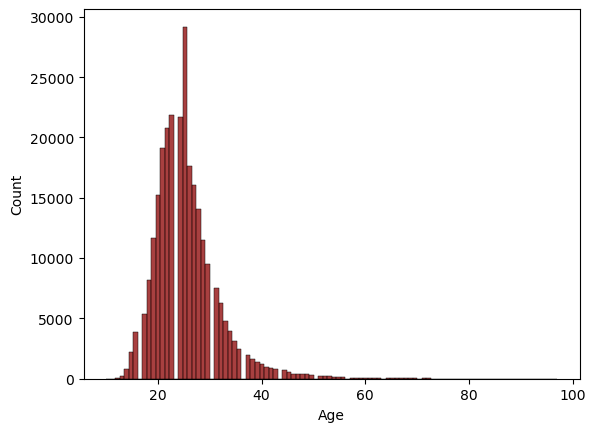

In [10]:
sns.histplot(df['Age'].dropna(), color='darkred', bins=100)

## Begin creating linear regression model

In [11]:
df.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,271116.000000,271116.00000,271116.000000,271116.000000
mean,68248.954396,25.556898,175.33897,70.702393,1978.378480
std,39022.286345,6.280857,9.27810,12.574690,29.877632
min,1.000000,10.000000,127.00000,25.000000,1896.000000
25%,34643.000000,22.000000,170.00000,63.000000,1960.000000
50%,68205.000000,25.000000,175.33897,70.702393,1988.000000
75%,102097.250000,28.000000,180.00000,75.000000,2002.000000
max,135571.000000,97.000000,226.00000,214.000000,2016.000000


### Label Encoding

Create a "Medal Value" representing the numerical value of all the medals won by an athlete (gold = 3, silver = 2, bronze = 1). This method of medal tallying is unofficially used by the olympics committee to rank participating countries. 

Verify that the number of gold, silver, bronzes, and non-medals match the total number of rows.

In [12]:
gold_cond = df["Medal"] == "Gold"
silver_cond = df["Medal"] == "Silver"
bronze_cond = df["Medal"] == "Bronze"
none_cond = df["Medal"].isnull()

golds = len(df[gold_cond])
silvers = len(df[silver_cond])
bronzes = len(df[bronze_cond])
nones = len(df[none_cond])

print("Number of golds: ", golds)
print("Number of silvers: ", silvers)
print("Number of bronzes: ", bronzes)
print("Number of nones: ", nones)
print("Total Medals: ", (golds + silvers + bronzes + nones))


Number of golds:  13372
Number of silvers:  13116
Number of bronzes:  13295
Number of nones:  231333
Total Medals:  271116


Create the separate "Medal Value" column assigning the respective medal weight.

In [13]:
df.loc[gold_cond, "Medal Value"] = 3
df.loc[silver_cond, "Medal Value"] = 2
df.loc[bronze_cond, "Medal Value"] = 1
df.loc[none_cond, "Medal Value"] = 0

#Check the first few medal winners to make sure values were added properly
df[df["Medal"].isnull() == False].head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Medal Value
3,4,Edgar Lindenau Aabye,M,34.0,175.33897,70.702393,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,3.0
37,15,Arvo Ossian Aaltonen,M,30.0,175.33897,70.702393,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze,1.0
38,15,Arvo Ossian Aaltonen,M,30.0,175.33897,70.702393,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze,1.0
40,16,Juhamatti Tapio Aaltonen,M,28.0,184.00000,85.000000,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze,1.0
41,17,Paavo Johannes Aaltonen,M,28.0,175.00000,64.000000,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze,1.0


Group data by athlete and total their medal value into a new dataframe.

In [14]:
by_athlete = df.groupby("Name")['Medal Value'].sum()
total_medals_sorted = by_athlete.sort_values(ascending=False)
total_medals_sorted.head(10)

Name
Michael Fred Phelps, II                            77.0
Larysa Semenivna Latynina (Diriy-)                 41.0
Nikolay Yefimovich Andrianov                       34.0
Ole Einar Bjrndalen                                33.0
Paavo Johannes Nurmi                               33.0
Birgit Fischer-Schmidt                             32.0
Borys Anfiyanovych Shakhlin                        31.0
Sawao Kato                                         31.0
Jennifer Elisabeth "Jenny" Thompson (-Cumpelik)    31.0
Mark Andrew Spitz                                  30.0
Name: Medal Value, dtype: float64

In [15]:
df_total_medals_sorted = total_medals_sorted.to_frame(name='Total Medal Value')
df_total_and_height = pd.merge(df_total_medals_sorted, df, on='Name')
df_total_and_height

,Name,Total Medal Value,ID,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Medal Value
0,"Michael Fred Phelps, II",77.0,94406,M,15.0,193.0,91.0,United States,USA,2000 Summer,2000,Summer,Sydney,Swimming,Swimming Men's 200 metres Butterfly,NaN,0.0
1,"Michael Fred Phelps, II",77.0,94406,M,19.0,193.0,91.0,United States,USA,2004 Summer,2004,Summer,Athina,Swimming,Swimming Men's 200 metres Freestyle,Bronze,1.0
2,"Michael Fred Phelps, II",77.0,94406,M,19.0,193.0,91.0,United States,USA,2004 Summer,2004,Summer,Athina,Swimming,Swimming Men's 4 x 100 metres Freestyle Relay,Bronze,1.0
3,"Michael Fred Phelps, II",77.0,94406,M,19.0,193.0,91.0,United States,USA,2004 Summer,2004,Summer,Athina,Swimming,Swimming Men's 4 x 200 metres Freestyle Relay,Gold,3.0
4,"Michael Fred Phelps, II",77.0,94406,M,19.0,193.0,91.0,United States,USA,2004 Summer,2004,Summer,Athina,Swimming,Swimming Men's 100 metres Butterfly,Gold,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,Hugo Ernesto Perez,0.0,93322,M,20.0,170.0,71.0,United States,USA,1984 Summer,1984,Summer,Los Angeles,Football,Football Men's Football,NaN,0.0
271112,Hugo Dufey,0.0,30424,M,38.0,182.0,83.0,Chile,CHI,1976 Summer,1976,Summer,Montreal,Shooting,Shooting Mixed Trap,NaN,0.0
271113,Hugo Dionisio Chila Ayov,0.0,20733,M,21.0,175.0,64.0,Ecuador,ECU,2008 Summer,2008,Summer,Beijing,Athletics,Athletics Men's Long Jump,NaN,0.0
271114,zzet nce,0.0,52087,M,23.0,172.0,85.0,Turkey,TUR,2004 Summer,2004,Summer,Athina,Weightlifting,Weightlifting Men's Light-Heavyweight,NaN,0.0


Remove irrelevant rows.

In [16]:
df_reduced = df_total_and_height[['Name', 'Total Medal Value', 'Height', 'Sport']]
df_reduced = df_reduced.drop_duplicates()
df_reduced

,Name,Total Medal Value,Height,Sport
0,"Michael Fred Phelps, II",77.0,193.0,Swimming
30,Larysa Semenivna Latynina (Diriy-),41.0,161.0,Gymnastics
49,Nikolay Yefimovich Andrianov,34.0,166.0,Gymnastics
73,Ole Einar Bjrndalen,33.0,178.0,Biathlon
83,Ole Einar Bjrndalen,33.0,178.0,Cross Country Skiing
...,...,...,...,...
271106,Hugo Ernesto Romero Iza,0.0,169.0,Shooting
271111,Hugo Ernesto Perez,0.0,170.0,Football
271112,Hugo Dufey,0.0,182.0,Shooting
271113,Hugo Dionisio Chila Ayov,0.0,175.0,Athletics


View the tallest olympians

In [17]:
df_reduced_by_height = df_reduced.sort_values(by="Height", ascending=False)
df_reduced_by_height.head(10)

,Name,Total Medal Value,Height,Sport
125691,Yao Ming,0.0,226.0,Basketball
57163,Tommy Loren Burleson,2.0,223.0,Basketball
18105,Arvydas Romas Sabonis,5.0,223.0,Basketball
245559,Gunther Behnke,0.0,221.0,Basketball
129858,Zhang Zhaoxu,0.0,221.0,Basketball
158120,Roberto Dueas Hernndez,0.0,221.0,Basketball
33977,Viktor Aleksandrovich Pankrashkin,3.0,220.0,Basketball
55236,Volodymyr Petrovych Tkachenko,2.0,220.0,Basketball
97357,"Lucien James ""Luc"" Longley",0.0,220.0,Basketball
148455,Peter John Ramos Fuentes,0.0,219.0,Basketball


## Data Visualization

In [18]:
from scipy import stats

In [19]:
def get_r(df):
    r, p_value = stats.pearsonr(df['Height'], df['Total Medal Value'])
    return r

def annotate_r(r):
    # Annotate the plot with the R value
    plt.annotate(f"R = {r:.2f}", xy=(0.1, 0.9), xycoords="axes fraction", fontsize=12)

def create_plot(sport, title):
    df_sport = df_reduced_by_height[df_reduced_by_height['Sport'] == sport]
    sns.lmplot(x='Height', y='Total Medal Value', data=df_sport, line_kws={'color': 'red'}, aspect=2)
    plt.xlabel('Athlete Height (cm)')
    plt.title(title)

    r = get_r(df_sport)
    annotate_r(r)

### Linear Regression of All Athletes

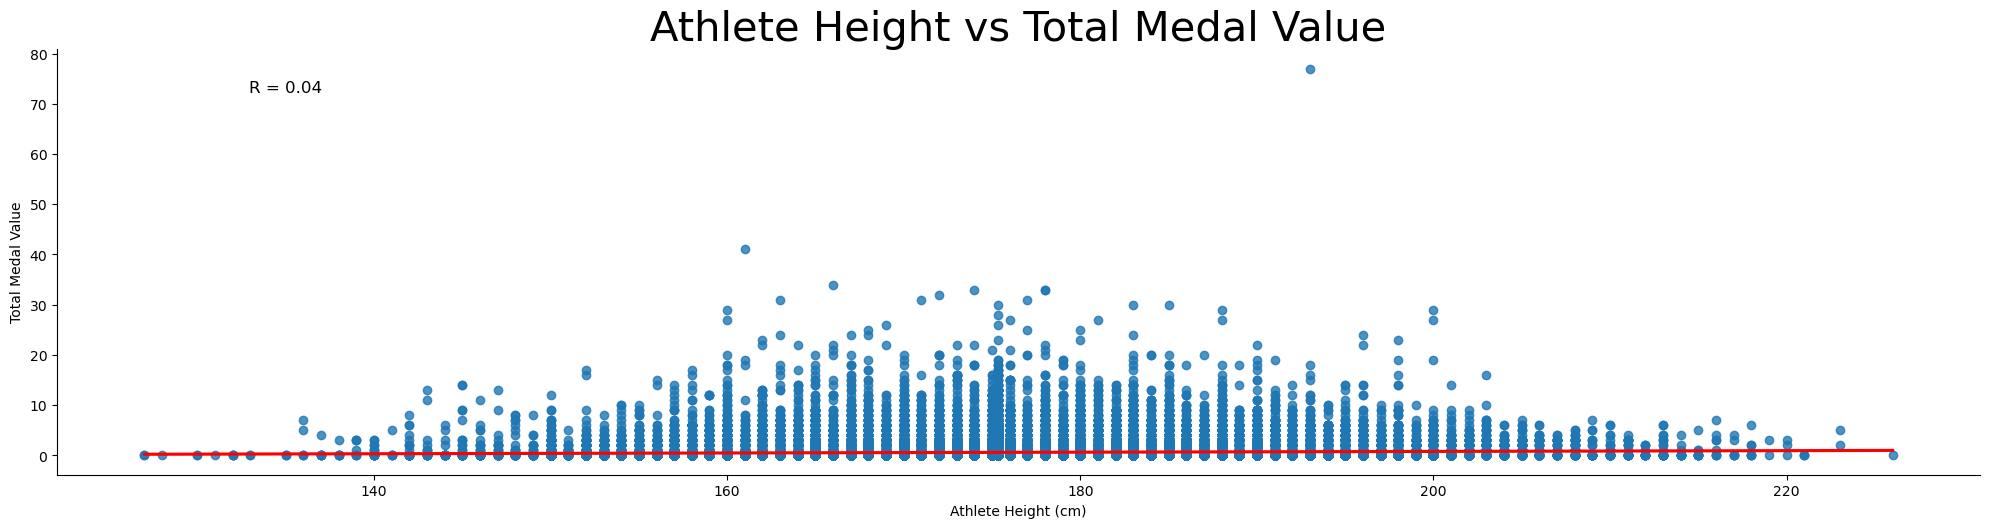

In [20]:
sns.lmplot(x='Height', y='Total Medal Value', data=df_reduced_by_height, line_kws={'color': 'red'}, aspect=4)
plt.xlabel('Athlete Height (cm)')
plt.title("Athlete Height vs Total Medal Value", fontsize=30)

r = get_r(df_reduced_by_height)
annotate_r(r)

## Linear Regression of Popular Sports

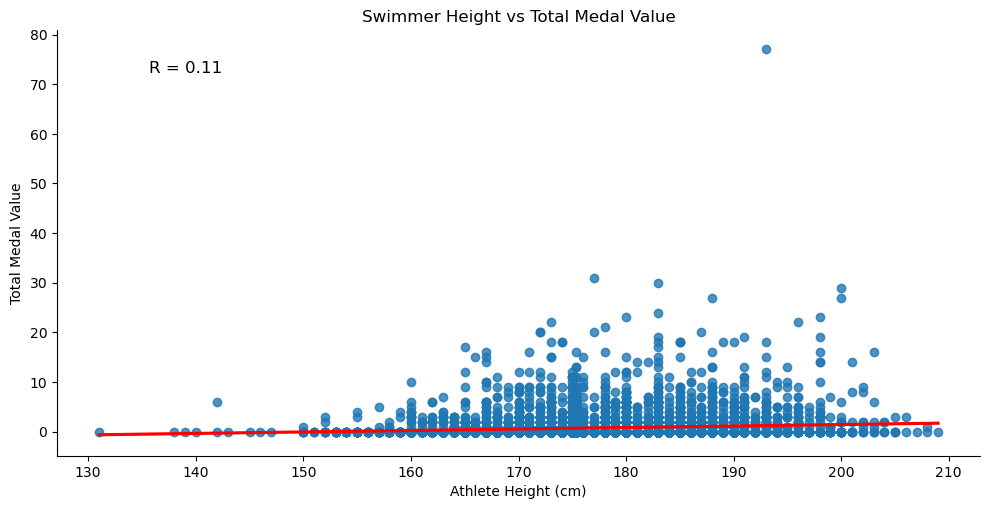

In [21]:
create_plot("Swimming", "Swimmer Height vs Total Medal Value")

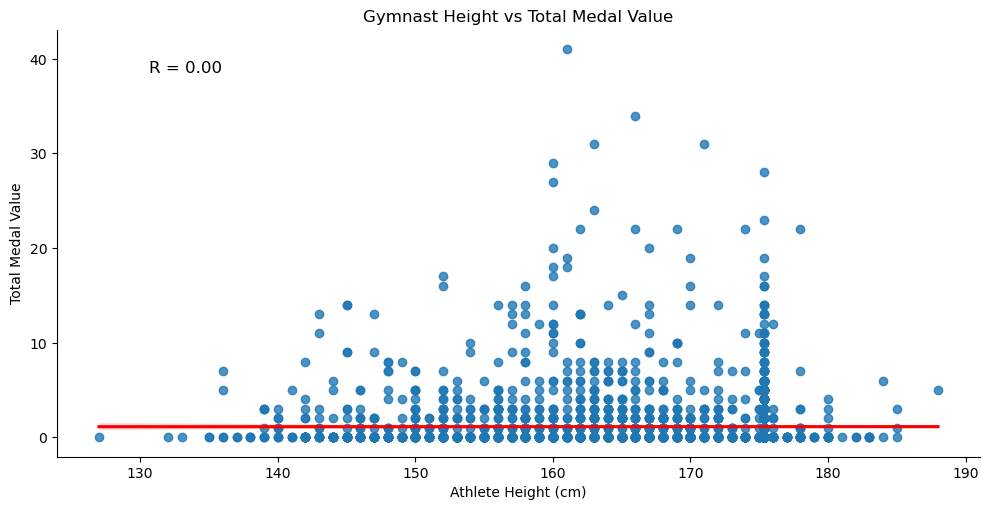

In [22]:
create_plot("Gymnastics", "Gymnast Height vs Total Medal Value")

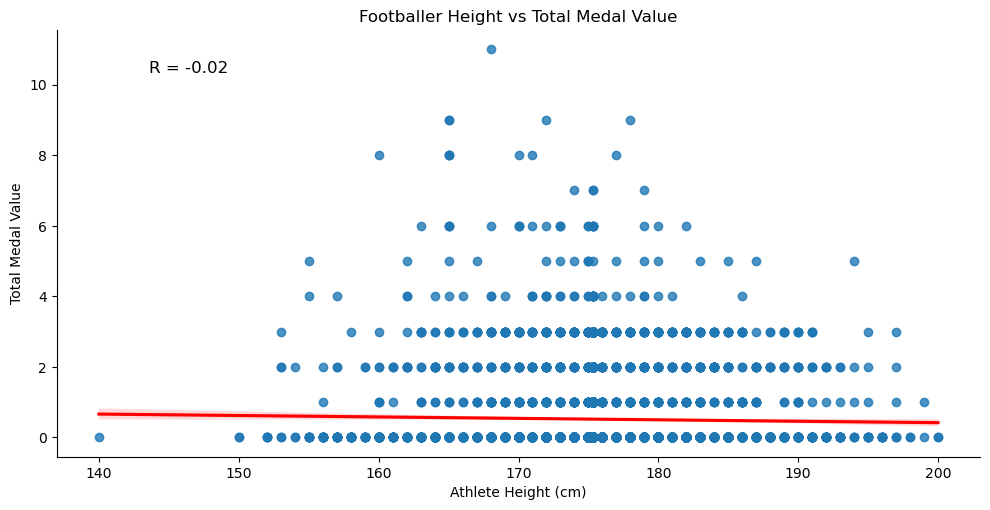

In [23]:
create_plot("Football", "Footballer Height vs Total Medal Value")

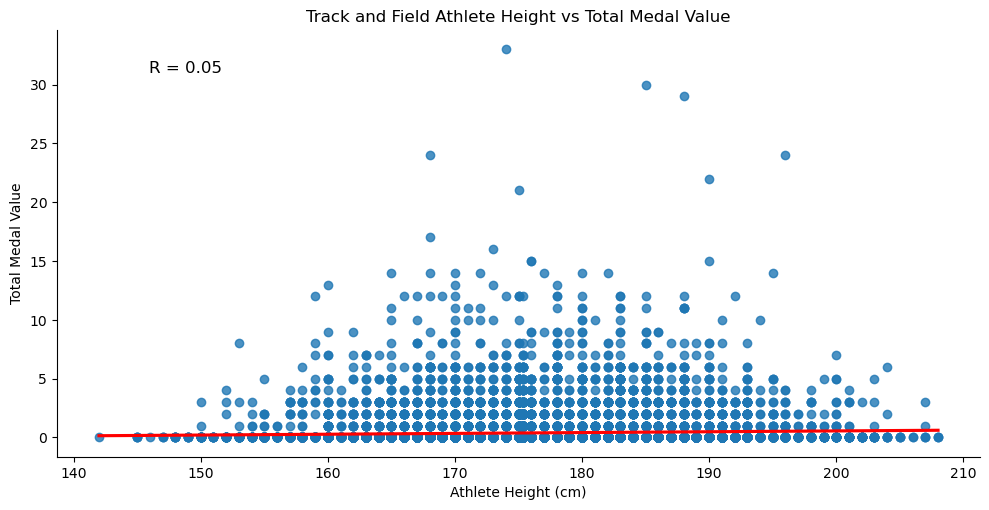

In [24]:
create_plot("Athletics", "Track and Field Athlete Height vs Total Medal Value")

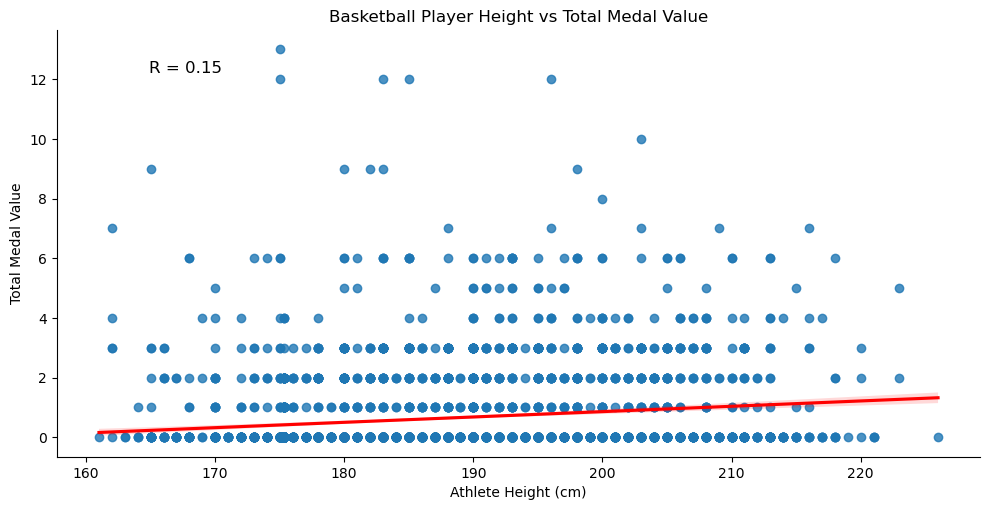

In [25]:
create_plot("Basketball", "Basketball Player Height vs Total Medal Value")

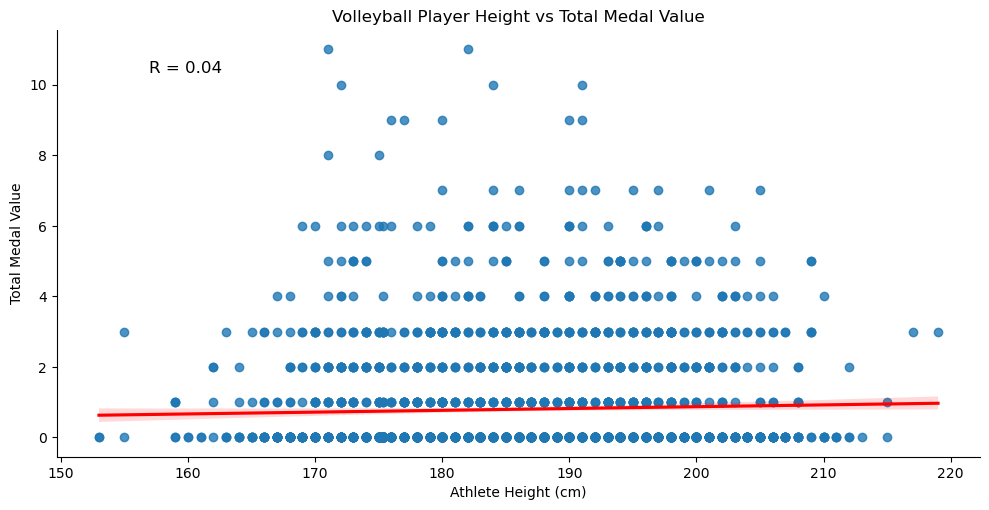

In [26]:
create_plot("Volleyball", "Volleyball Player Height vs Total Medal Value")

# Conclusion & Next Steps

Athlete height and performance in the olympics are shown to have very little and, in some cases, negative correlation with one another. Even when looking at individual sports, these factors had a correlation constant ranging from -0.02 to 0.15, which suggests no correlation.

Looking deeper into individual sports, the data suggests a slight advantage for shorter soccer players and a slight advantage for taller basketball players, which is inline with public perseption.

Future analysis could include event-specific data such as individual times and points scored to better represent athletes who did not recieve a medal.   